In [1]:
import datasets
import peft
import pickle
import pytest, ipytest
import transformers

from datasets import(
    load_dataset, 
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)

from peft import(
    LoftQConfig,
    LoraConfig,
    get_peft_model,
)

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from trl import SFTTrainer, SFTConfig
# allows fast processing of datasets

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-03 19:58:16.092729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743710296.106816 3576043 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743710296.111340 3576043 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743710296.124398 3576043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

In [2]:
%run training_functions.ipynb

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [6]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")

In [7]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B")

In [8]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)

In [9]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [10]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

In [11]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [12]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [13]:
l_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=2))

In [14]:
l_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.645400,2.585748,0.000430
2,0.647200,2.581959,0.000488
3,0.651600,2.580839,0.000371


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6495066409309705, metrics={'train_runtime': 1129.4105, 'train_samples_per_second': 1.328, 'train_steps_per_second': 0.043, 'total_flos': 8976366305280000.0, 'train_loss': 0.6495066409309705})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6454,2.585748,0.000430
2.0,0.6472,2.581959,0.000488
3.0,0.6516,2.580839,0.000371


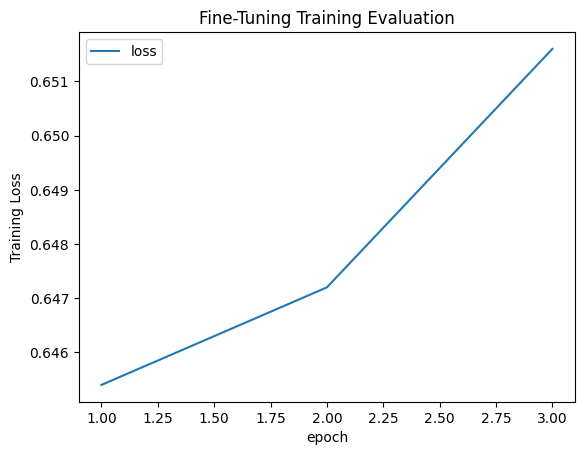

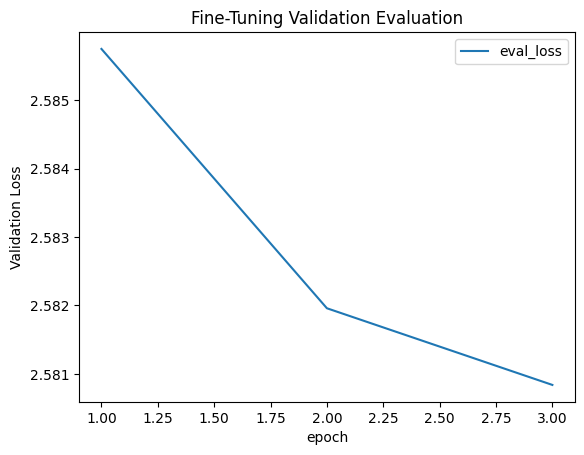

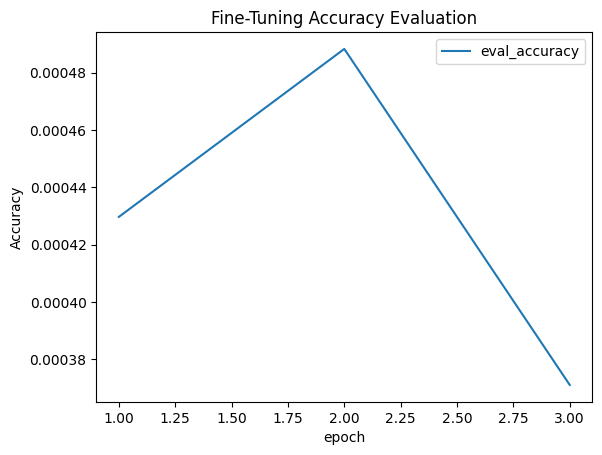

In [15]:
output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [16]:
l2_trainer = make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=6))

In [17]:
l2_trainer.train() 

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.647100,2.578312,0.000332
12,0.649500,2.576081,0.000430
18,0.644700,2.574547,0.000293
24,0.648400,2.573655,0.000313
30,0.648200,2.572644,0.000254
36,0.646600,2.572220,0.000215
42,0.645100,2.571947,0.000234
48,0.648100,2.571733,0.000254


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6472243020931879, metrics={'train_runtime': 2925.2627, 'train_samples_per_second': 0.513, 'train_steps_per_second': 0.016, 'total_flos': 8976366305280000.0, 'train_loss': 0.6472243020931879})

,loss,eval_loss,eval_accuracy
steps,,,
6,0.6471,2.578312,0.000332
12,0.6495,2.576081,0.000430
18,0.6447,2.574547,0.000293
24,0.6484,2.573655,0.000313
30,0.6482,2.572644,0.000254
36,0.6466,2.572220,0.000215
42,0.6451,2.571947,0.000234
48,0.6481,2.571733,0.000254


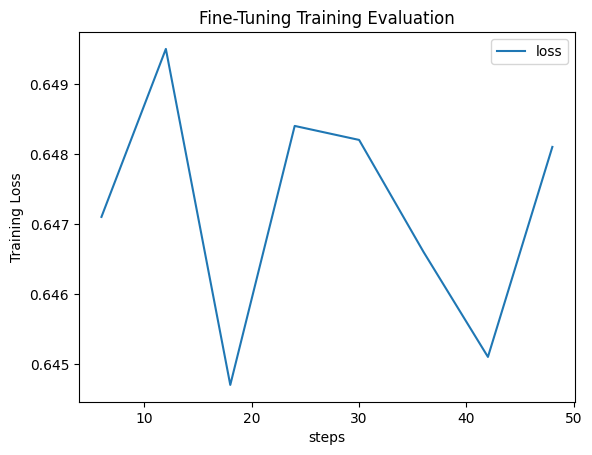

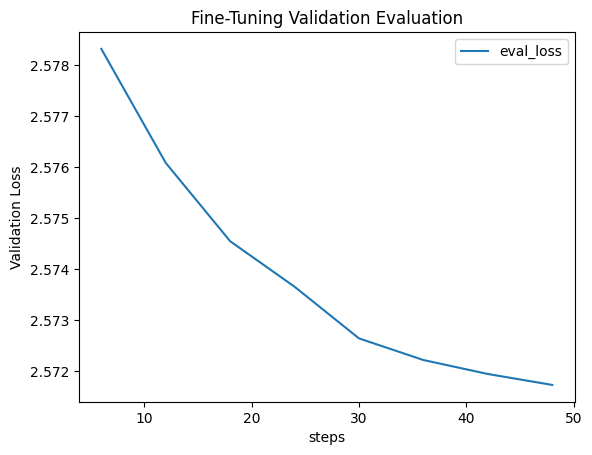

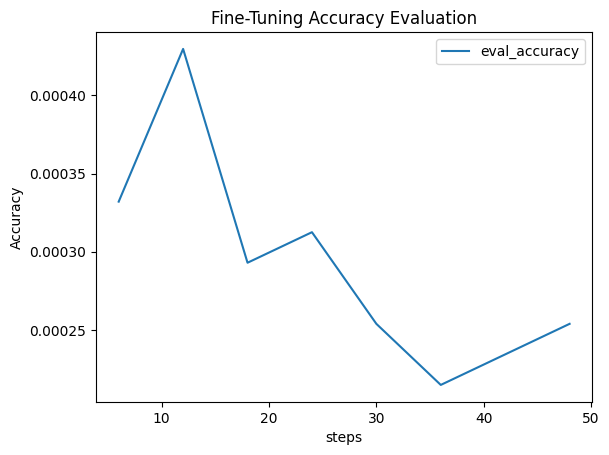

In [18]:
output=get_training_output(l2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [19]:
l_trainer.model.save_pretrained('./fine_tuned/lla/')
l2_trainer.model.save_pretrained('./fine_tuned/lla2/')

In [20]:
l_trainer.processing_class.save_pretrained('./fine_tuned/lla_token/')
l2_trainer.model.save_pretrained('./fine_tuned/lla2_token/')